## Uncertainty Quantification and Robustness Studies

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt

src_path = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils import MIMONetDataset, DeepONetDataset, ChannelScaler
from mimonet_drop import MIMONet_Drop
from mimonet import MIMONet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)

### Set Directory Path

In [4]:
working_dir = "/projects/bcnx/kazumak2/MIMONet/HeatExchanger"
data_dir = os.path.join(working_dir, "data")

## Load datasets and Set dataloader

In [5]:
# trunk dataset
trunk_input = np.load(os.path.join(data_dir, "share/trunk.npz"))['trunk']

# min-max scaling [-1, 1]
trunk_input[:, 0] = 2 * (trunk_input[:, 0] - np.min(trunk_input[:, 0])) / (np.max(trunk_input[:, 0]) - np.min(trunk_input[:, 0])) - 1
trunk_input[:, 1] = 2 * (trunk_input[:, 1] - np.min(trunk_input[:, 1])) / (np.max(trunk_input[:, 1]) - np.min(trunk_input[:, 1])) - 1

# branch input dataset
branch = np.load(os.path.join(data_dir, "branch.npz"))

branch1 = branch['branch1']
branch2 = branch['branch2']

print("Branch1 shape:", branch1.shape)
print("Branch2 shape:", branch2.shape)

# split the dataset into training and testing sets
train_size = int(0.7 * len(branch1))
cal_size = int(0.1 * len(branch1))
test_size = len(branch1) - train_size - cal_size

train_branch1, cal_branch1, test_branch1 = branch1[:train_size], branch1[train_size:train_size+cal_size], branch1[train_size+cal_size:]
train_branch2, cal_branch2, test_branch2 = branch2[:train_size], branch2[train_size:train_size+cal_size], branch2[train_size+cal_size:]


# create a dictionary for the output channel names
# 0: turb-kinetic-energy
# 1: pressure
# 2: temperature
# 3: z-velocity
# 4: y-velocity
# 5: x-velocity
# 6: velocity-magnitude

dict_channel = {
    0: 'turb-kinetic-energy',
    1: 'pressure',
    2: 'temperature',
    3: 'z-velocity',
    4: 'y-velocity',
    5: 'x-velocity',
    6: 'velocity-magnitude'
}

# select the output channel
target_channel = [1, 3, 4, 5, 6]

# print the selected output channel names
# target_label is used to store the names of the selected output channels for further processing (e.g., plotting)
print("Selected output channels:")
target_label = []
for channel in target_channel:
    print(dict_channel[channel])
    target_label.append(dict_channel[channel])    
    
# target dataset
target = np.load(os.path.join(data_dir, "target.npy"))

print("Target shape:", target.shape)

## extract the output channels
## select the desired channels using the list (target_channel)
target = target[..., target_channel]


# split the target dataset into training and testing sets
train_target = target[:train_size]
cal_target = target[train_size:train_size+cal_size]
test_target = target[train_size+cal_size:]


#
print("Train target shape:", train_target.shape)
print("Cal target shape:", cal_target.shape)
print("Test target shape:", test_target.shape)

# (# train samples, 2) 
# get the mean and standard deviation of each channel
mean_branch1 = np.mean(train_branch1, axis=0)
std_branch1 = np.std(train_branch1, axis=0)

print("Mean of branch1:", mean_branch1)
print("Std of branch1:", std_branch1)

# (# train samples, 100)
mean_branch2 = np.mean(train_branch2)
std_branch2 = np.std(train_branch2)

print("Mean of branch2:", mean_branch2)
print("Std of branch2:", std_branch2)

# normalize the branch data using the mean and std
train_branch_1 = (train_branch1 - mean_branch1) / std_branch1
cal_branch_1 = (cal_branch1 - mean_branch1) / std_branch1
test_branch_1 = (test_branch1 - mean_branch1) / std_branch1
train_branch_2 = (train_branch2 - mean_branch2) / std_branch2
cal_branch_2 = (cal_branch2 - mean_branch2) / std_branch2
test_branch_2 = (test_branch2 - mean_branch2) / std_branch2

# print the shapes of the normalized data
print("Shape of normalized train_branch1:", train_branch_1.shape)
print("Shape of normalized cal_branch1:", cal_branch_1.shape)
print("Shape of normalized test_branch1:", test_branch_1.shape)
print("Shape of normalized train_branch2:", train_branch_2.shape)
print("Shape of normalized cal_branch2:", cal_branch_2.shape)
print("Shape of normalized test_branch2:", test_branch_2.shape)

# scaling the target data
'''  
note: reverse the scaling for the target data
train_target = scaler.inverse_transform(train_target_scaled)
test_target = scaler.inverse_transform(test_target_scaled)
'''
scaler = ChannelScaler(method='minmax', feature_range=(-1, 1))
scaler.fit(train_target)
train_target_scaled = scaler.transform(train_target)
cal_target_scaled = scaler.transform(cal_target)
test_target_scaled = scaler.transform(test_target)

print("Shape of scaled train_target:", train_target_scaled.shape)
print("Shape of scaled cal_target:", cal_target_scaled.shape)
print("Shape of scaled test_target:", test_target_scaled.shape)

Branch1 shape: (1546, 2)
Branch2 shape: (1546, 100)
Selected output channels:
pressure
z-velocity
y-velocity
x-velocity
velocity-magnitude
Target shape: (1546, 3977, 7)
Train target shape: (1082, 3977, 5)
Cal target shape: (154, 3977, 5)
Test target shape: (310, 3977, 5)
Mean of branch1: [  4.51240586 292.51768744]
Std of branch1: [ 0.26259557 17.00554419]
Mean of branch2: 12585.61180600377
Std of branch2: 6301.4523906758695
Shape of normalized train_branch1: (1082, 2)
Shape of normalized cal_branch1: (154, 2)
Shape of normalized test_branch1: (310, 2)
Shape of normalized train_branch2: (1082, 100)
Shape of normalized cal_branch2: (154, 100)
Shape of normalized test_branch2: (310, 100)
Shape of scaled train_target: (1082, 3977, 5)
Shape of scaled cal_target: (154, 3977, 5)
Shape of scaled test_target: (310, 3977, 5)


## Uncertainty Quantification

## Initialization of Model with Dropout

In [6]:
# test dataset and dataloader
test_dataset = MIMONetDataset(
    [test_branch_1, test_branch_2],  # branch_data_list
    trunk_input,                     # trunk_data
    test_target_scaled               # target_data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # set to 1 for testing
    shuffle=False,
    num_workers=0
)

# calibration dataset and dataloader
cal_dataset = MIMONetDataset(
    [cal_branch_1, cal_branch_2],  # branch_data_list
    trunk_input,                    # trunk_data
    cal_target_scaled               # target_data
)

cal_loader = torch.utils.data.DataLoader(
    cal_dataset,
    batch_size=1,  # set to 1 for calibration
    shuffle=False,
    num_workers=0
)

In [7]:
# MIMONet with Dropout

# Architecture parameters
dim = 256
branch_input_dim1 = 2
branch_input_dim2 = 100
trunk_input_dim = 2

# Define the model arguments for orig_MIMONet
model_args = {
    'branch_arch_list': [
        [branch_input_dim1, 512, 512, 512, dim],
        [branch_input_dim2, 512, 512, 512, dim]
    ],
    'trunk_arch': [trunk_input_dim, 256, 256, 256, dim],
    'num_outputs': target.shape[-1] -1,  # number of output channels
    'activation_fn': nn.ReLU,
    'merge_type': 'mul',
    'dropout_p': 0.1  # Dropout rate
}

model = MIMONet_Drop(**model_args)
model = model.to(device)

# Print parameter count
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params:,}")

Total number of parameters: 1,762,052


### Ensembling

In [8]:
import copy, random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

N = 20  # Number of ensemble members
ensemble = []

for _ in range(N):
    m = MIMONet_Drop(**model_args)
    m.load_state_dict(torch.load('HeatExchanger/checkpoints/best_model_dropout.pt'))
    m.to(device)
    m.train()  # Enable dropout during inference
    ensemble.append(m)

In [9]:
# Example: get predictions from all models in the ensemble
def ensemble_predict(ensemble, branch_batch, trunk_batch):
    preds = []
    with torch.no_grad():
        for m in ensemble:
            preds.append(m(branch_batch, trunk_batch).cpu().numpy())
    return np.stack(preds, axis=0)  # shape: (N, batch_size, ...)

def get_ensemble_predictions(ensemble, data_loader, device=device):

    all_targets = []
    all_preds = []

    # Set all models to evaluation mode
    
    for i, (branch_data, trunk_data, target_data) in enumerate(data_loader):
        branch_data = [bd.to(device).float() for bd in branch_data]
        trunk_data = trunk_data.to(device).float()
        target_data = target_data.to(device).float()

        # Predict from ensemble: returns shape (E, batch_size, ...)
        preds = ensemble_predict(ensemble, branch_data, trunk_data)
        all_preds.append(preds)  # Collect each batch’s ensemble predictions
        all_targets.append(target_data.cpu().numpy())

    # Concatenate across batches
    all_preds = np.concatenate(all_preds, axis=1)  # [E, total_samples, ...]
    all_targets = np.concatenate(all_targets, axis=0)  # [total_samples, ...]

    print('Shape of all_preds:', all_preds.shape)

    return all_preds, all_targets

### Run ensemble on the calibration set

In [10]:
# Collect predictions on calibration set
cal_preds, cal_targets = get_ensemble_predictions(ensemble, cal_loader, device=device)

# Ensemble mean and std in scaled space
cal_mean = np.mean(cal_preds, axis=0)
cal_std  = np.std(cal_preds, axis=0)

# Rescale properly
cal_mean_rescaled = scaler.inverse_transform(cal_mean)
cal_std_rescaled  = scaler.inverse_transform_std(cal_std)
cal_targets_rescaled = scaler.inverse_transform(cal_targets)[..., :4]


print("Shape of cal_mean_rescaled:", cal_mean_rescaled.shape)
print("Shape of cal_std_rescaled:", cal_std_rescaled.shape)
print("Shape of cal_targets_rescaled:", cal_targets_rescaled.shape)

Shape of all_preds: (20, 154, 3977, 4)
Shape of cal_mean_rescaled: (154, 3977, 4)
Shape of cal_std_rescaled: (154, 3977, 4)
Shape of cal_targets_rescaled: (154, 3977, 4)


### Variance scaling

In [11]:
# Z-scores on calibration set
z_cal = (cal_targets_rescaled - cal_mean_rescaled) / (cal_std_rescaled + 1e-12)
z_cal_flat = z_cal.reshape(-1, z_cal.shape[-1])

# Per-channel scale factor α
alpha = z_cal_flat.std(axis=0)   # (num_channels,)
print("Variance scaling factors:", alpha)


Variance scaling factors: [0.76207453 0.90054977 1.0000706  0.92657316]


### Run ensemble on test dataset

In [12]:
ensemble_preds, all_targets = get_ensemble_predictions(ensemble, test_loader, device=device)

mean_preds = np.mean(ensemble_preds, axis=0)     # scaled space
stddev_preds = np.std(ensemble_preds, axis=0)    # scaled space

# Rescale means and stddevs
mean_preds_rescaled = scaler.inverse_transform(mean_preds)
stddev_preds_rescaled = scaler.inverse_transform_std(stddev_preds)
all_targets_rescaled = scaler.inverse_transform(all_targets)[..., :4]

print("Shape of mean_preds_rescaled:", mean_preds_rescaled.shape)
print("Shape of stddev_preds_rescaled:", stddev_preds_rescaled.shape)
print("Shape of all_targets_rescaled:", all_targets_rescaled.shape)

Shape of all_preds: (20, 310, 3977, 4)
Shape of mean_preds_rescaled: (310, 3977, 4)
Shape of stddev_preds_rescaled: (310, 3977, 4)
Shape of all_targets_rescaled: (310, 3977, 4)


In [13]:
# compute mean relative l2 error per output channel
mean_l2_0 = np.mean(np.linalg.norm(mean_preds_rescaled[..., 0] - all_targets_rescaled[..., 0], axis=1) / np.linalg.norm(all_targets_rescaled[..., 0], axis=1))
mean_l2_1 = np.mean(np.linalg.norm(mean_preds_rescaled[..., 1] - all_targets_rescaled[..., 1], axis=1) / np.linalg.norm(all_targets_rescaled[..., 1], axis=1))
mean_l2_2 = np.mean(np.linalg.norm(mean_preds_rescaled[..., 2] - all_targets_rescaled[..., 2], axis=1) / np.linalg.norm(all_targets_rescaled[..., 2], axis=1))
mean_l2_3 = np.mean(np.linalg.norm(mean_preds_rescaled[..., 3] - all_targets_rescaled[..., 3], axis=1) / np.linalg.norm(all_targets_rescaled[..., 3], axis=1))
print(f"Mean relative L2 error (channel 0): {mean_l2_0:.4f}")
print(f"Mean relative L2 error (channel 1): {mean_l2_1:.4f}")
print(f"Mean relative L2 error (channel 2): {mean_l2_2:.4f}")
print(f"Mean relative L2 error (channel 3): {mean_l2_3:.4f}")

Mean relative L2 error (channel 0): 0.0630
Mean relative L2 error (channel 1): 0.1600
Mean relative L2 error (channel 2): 0.1455
Mean relative L2 error (channel 3): 0.1211


### Calibration using \alpha

In [14]:
stddev_preds_rescaled_prime = stddev_preds_rescaled * alpha[None, None, :]

### Conformal calibration factors (q)

In [15]:
r = np.abs(cal_targets_rescaled - cal_mean_rescaled) / (cal_std_rescaled * alpha[None,None,:] + 1e-12)
q = np.quantile(r.reshape(-1, r.shape[-1]), 0.95, axis=0)  # for 95% intervals
print("Conformal factors (q):", q)

lower = mean_preds_rescaled - q[None,None,:] * stddev_preds_rescaled_prime
upper = mean_preds_rescaled + q[None,None,:] * stddev_preds_rescaled_prime

Conformal factors (q): [2.126453  2.0928762 2.0852742 2.1090283]


## Verify on the held-out test set

In [16]:
from scipy.stats import gaussian_kde, pearsonr, spearmanr
# ---------- Apply calibration ----------
# variance scaling
stddev_preds_rescaled_prime = stddev_preds_rescaled * alpha[None, None, :]   # σ′

# conformal adjustment
lower = mean_preds_rescaled - q[None, None, :] * stddev_preds_rescaled_prime
upper = mean_preds_rescaled + q[None, None, :] * stddev_preds_rescaled_prime
y = all_targets_rescaled
inside = (y >= lower) & (y <= upper)

# Coverage per channel (empirical)
cov_conf = inside.reshape(-1, y.shape[-1]).mean(axis=0) * 100
cov_all = inside.mean() * 100
print("Conformal 95% coverage per channel:", cov_conf)
print("Conformal 95% overall:", cov_all)

# ---------- Z-scores with σ′ ----------
eps = 1e-12
z = (all_targets_rescaled - mean_preds_rescaled) / (stddev_preds_rescaled_prime + eps)
z_flat = z.reshape(-1, z.shape[-1])  # (N_all, C)

# ---------- Compute correlations ----------
corr_results = {}
for ch in range(4):
    x = stddev_preds_rescaled_prime[..., ch].reshape(-1)
    yerr = np.abs(all_targets_rescaled[..., ch] - mean_preds_rescaled[..., ch]).reshape(-1)
    r, _ = pearsonr(x, yerr)
    rho, _ = spearmanr(x, yerr)
    corr_results[f"Channel {ch}"] = {"pearson": r, "spearman": rho}

Conformal 95% coverage per channel: [95.06671425 94.98170934 94.98957717 95.0564942 ]
Conformal 95% overall: 95.02362373972925


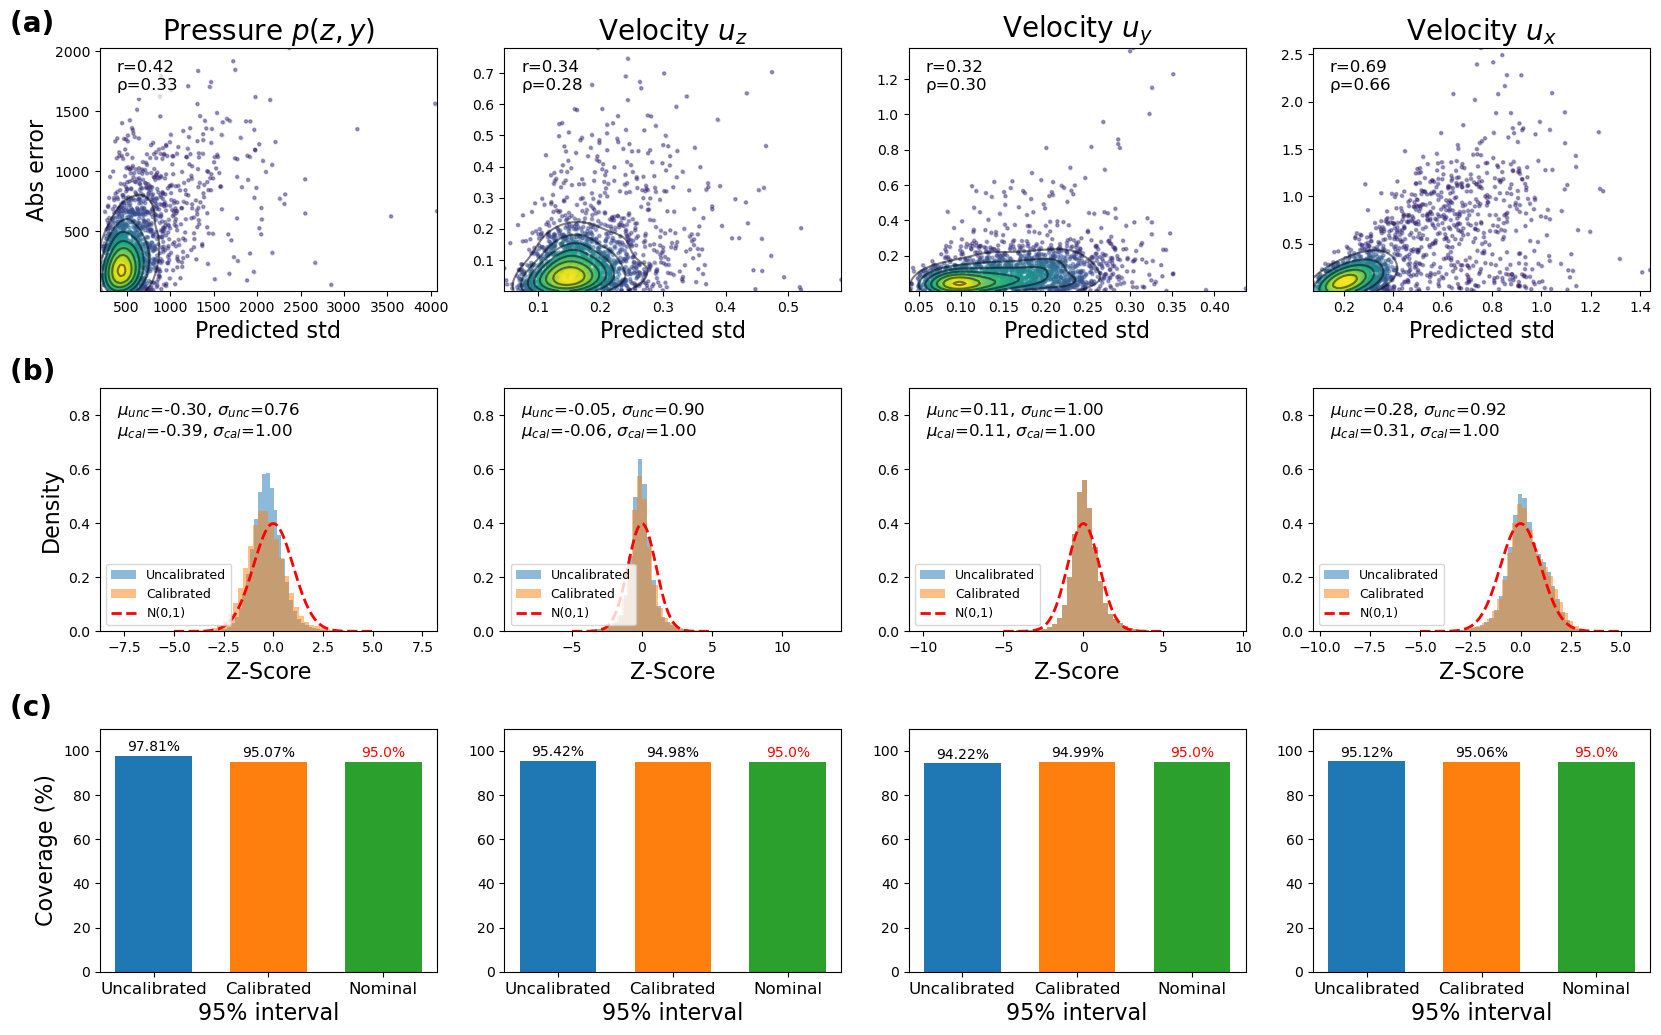

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr, spearmanr

channel_names = [r"Pressure $p(z,y)$", r"Velocity $u_z$", r"Velocity $u_y$", r"Velocity $u_x$"]

# ---------- Uncalibrated Z-scores ----------
eps = 1e-12
z_uncal = (all_targets_rescaled - mean_preds_rescaled) / (stddev_preds_rescaled + eps)
z_uncal_flat = z_uncal.reshape(-1, z_uncal.shape[-1])

# ---------- Calibrated Z-scores ----------
stddev_preds_rescaled_prime = stddev_preds_rescaled * alpha[None, None, :]
z_cal = (all_targets_rescaled - mean_preds_rescaled) / (stddev_preds_rescaled_prime + eps)
z_cal_flat = z_cal.reshape(-1, z_cal.shape[-1])

# ---------- Conformal coverage (Calibrated) ----------
lower_cal = mean_preds_rescaled - q[None, None, :] * stddev_preds_rescaled_prime
upper_cal = mean_preds_rescaled + q[None, None, :] * stddev_preds_rescaled_prime
inside_cal = (all_targets_rescaled >= lower_cal) & (all_targets_rescaled <= upper_cal)
cov_conf = inside_cal.reshape(-1, all_targets_rescaled.shape[-1]).mean(axis=0) * 100

# ---------- Uncalibrated coverage ----------
lower_unc = mean_preds_rescaled - 1.96 * stddev_preds_rescaled
upper_unc = mean_preds_rescaled + 1.96 * stddev_preds_rescaled
inside_unc = (all_targets_rescaled >= lower_unc) & (all_targets_rescaled <= upper_unc)
cov_unc = inside_unc.reshape(-1, all_targets_rescaled.shape[-1]).mean(axis=0) * 100

# ---------- Flatten for Row 1 ----------
stds_flat = stddev_preds_rescaled.reshape(-1, stddev_preds_rescaled.shape[-1])
errors_flat = np.abs(all_targets_rescaled - mean_preds_rescaled).reshape(-1, all_targets_rescaled.shape[-1])

# ---------- Plot ----------
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4)

# Row 1: scatter + density (uncalibrated, with correlations inside panel)
for ch in range(4):
    ax = axes[0, ch]
    x = stds_flat[:2000, ch]
    y = errors_flat[:2000, ch]
    ax.scatter(x, y, alpha=0.2, s=5)

    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)(xy)
    idx = kde.argsort()
    x, y, kde = x[idx], y[idx], kde[idx]
    ax.scatter(x, y, c=kde, s=5, cmap="viridis", alpha=0.3)

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(gaussian_kde(xy)(positions), X.shape)
    ax.contour(X, Y, Z, colors='k', alpha=0.5)

    # correlation values (Pearson & Spearman)
    r, _ = pearsonr(stds_flat[:, ch], errors_flat[:, ch])
    rho, _ = spearmanr(stds_flat[:, ch], errors_flat[:, ch])
    ax.text(0.05, 0.95, f"r={r:.2f}\nρ={rho:.2f}",
            transform=ax.transAxes, ha='left', va='top',
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_xlabel("Predicted std", fontsize=16)
    if ch == 0:
        ax.set_ylabel("Abs error", fontsize=16)
    ax.set_title(f"{channel_names[ch]}", fontsize=20)

# Row 2: z-score histograms (before vs after calibration)
x_vals = np.linspace(-5, 5, 400)
normal_pdf = (1.0/np.sqrt(2*np.pi)) * np.exp(-0.5*x_vals**2)

for ch in range(4):
    ax = axes[1, ch]
    zz_uncal = z_uncal_flat[:, ch]
    zz_cal = z_cal_flat[:, ch]

    ax.hist(zz_uncal, bins=60, density=True, alpha=0.5, color="tab:blue", label="Uncalibrated")
    ax.hist(zz_cal, bins=60, density=True, alpha=0.5, color="tab:orange", label="Calibrated")
    ax.plot(x_vals, normal_pdf, "r--", lw=2, label="N(0,1)")

    ax.text(0.05, 0.95, f"$μ_{{unc}}$={zz_uncal.mean():.2f}, $σ_{{unc}}$={zz_uncal.std():.2f}\n"
                        f"$μ_{{cal}}$={zz_cal.mean():.2f}, $σ_{{cal}}$={zz_cal.std():.2f}",
            transform=ax.transAxes, ha='left', va='top',
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_xlabel("Z-Score", fontsize=16)
    if ch == 0:
        ax.set_ylabel("Density", fontsize=16)
    ax.legend(fontsize=9, loc='lower left')
    ax.set_ylim(0, 0.9)

# Row 3: 95% coverage bars (Uncal vs Cal vs Nominal, no legend, custom xticks)
for ch in range(4):
    ax = axes[2, ch]
    width = 0.2   # wider spacing since we’ll label directly
    x_pos = [-0.3, 0, 0.3]  # positions for three bars

    bars1 = ax.bar(x_pos[0], cov_unc[ch], width=width, color="tab:blue")
    bars2 = ax.bar(x_pos[1], cov_conf[ch], width=width, color="tab:orange")
    bars3 = ax.bar(x_pos[2], 95.0, width=width, color="tab:green")

    # annotate
    ax.text(bars1[0].get_x() + bars1[0].get_width()/2, cov_unc[ch] + 1,
            f"{cov_unc[ch]:.2f}%", ha='center', va='bottom', fontsize=10)
    ax.text(bars2[0].get_x() + bars2[0].get_width()/2, cov_conf[ch] + 1,
            f"{cov_conf[ch]:.2f}%", ha='center', va='bottom', fontsize=10)
    ax.text(bars3[0].get_x() + bars3[0].get_width()/2, 95 + 1,
            "95.0%", ha='center', va='bottom', fontsize=10, color='red')

    # xticks with labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(["Uncalibrated", "Calibrated", "Nominal"], fontsize=12, rotation=0)

    ax.set_ylim(0, 110)
    ax.set_xlabel("95% interval", fontsize=16)
    if ch == 0:
        ax.set_ylabel("Coverage (%)", fontsize=16)


# ---------- Row labels ----------
fig.text(0.08, 0.90, "(a) ", va='center', ha='left', fontsize=20, fontweight="bold")
fig.text(0.08, 0.61, "(b) ", va='center', ha='left', fontsize=20, fontweight="bold")
fig.text(0.08, 0.33, "(c) ", va='center', ha='left', fontsize=20, fontweight="bold")

plt.savefig(working_dir + "/analysis/uq_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


## Robustness

In [18]:
# --- Add Gaussian noise in [-1,1] scaled space ---
def add_noise_minmax(branch_tensors, lam):
    """
    Add Gaussian noise to branch inputs in scaled space [-1,1].
    lam: noise std (relative to scaled range)
    """
    noisy = []
    for b in branch_tensors:
        noise = torch.randn_like(b) * lam
        noisy.append(b + noise)
    return noisy

In [55]:
import numpy as np
import torch, time

def eval_with_noise_dropout(model, loader, noise_levels, device="cuda", N_mc=20, stochastic=True):
    """
    Evaluate model robustness against injected Gaussian noise and record inference time.

    Returns:
        results: dict[lam] = {
            "targets": np.ndarray,
            "mean_preds": np.ndarray,
            "std_preds": np.ndarray,
            "inference_time": float   # seconds per sample
        }
    """
    results = {}

    for lam in noise_levels:
        preds_mc = []
        targets_all = []
        total_time = 0.0
        total_samples = 0

        with torch.no_grad():
            for i_mc in range(N_mc if stochastic else 1):
                model.train() if stochastic else model.eval()

                all_preds, all_targets = [], []
                start_time = time.time()  # start timing MC pass

                for branches, trunk, target in loader:
                    noisy_branches = add_noise_minmax(branches, lam)
                    noisy_branches = [b.to(device) for b in noisy_branches]
                    trunk = trunk.to(device)
                    target = target.to(device)

                    out = model(noisy_branches, trunk)
                    all_preds.append(out.cpu().numpy())
                    all_targets.append(target.cpu().numpy())

                    total_samples += target.shape[0]

                total_time += time.time() - start_time  # accumulate total inference time
                preds_mc.append(np.concatenate(all_preds, axis=0))
                targets_all = np.concatenate(all_targets, axis=0)

        preds_mc = np.stack(preds_mc, axis=0)
        mean_preds = preds_mc.mean(axis=0)
        std_preds = preds_mc.std(axis=0) if stochastic else np.zeros_like(mean_preds)

        targets_all = targets_all[..., :mean_preds.shape[-1]]

        avg_time_per_sample = total_time / total_samples

        results[lam] = {
            "targets": targets_all,
            "mean_preds": mean_preds,
            "std_preds": std_preds,
            "inference_time": avg_time_per_sample
        }

    return results


In [56]:
model_dropout = MIMONet_Drop(**model_args)
model_dropout.load_state_dict(torch.load('HeatExchanger/checkpoints/best_model_dropout.pt'))
model_dropout = model_dropout.to(device)

In [57]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

### (1) Dropout-based stochastic (MC) robustness

In [58]:
robustness_mc = eval_with_noise_dropout(
    model_dropout, test_loader,
    noise_levels=noise_levels,
    device=device, N_mc=20, stochastic=True
)


### (2) Deterministic reference (dropout disabled)

In [59]:
robustness_det = eval_with_noise_dropout(
    model_dropout, test_loader,
    noise_levels=noise_levels,
    device=device, N_mc=1, stochastic=False
)


In [66]:
for lam in noise_levels:
    print(f"Noise {lam:.2f}:")
    print(f"  Deterministic time: {robustness_det[lam]['inference_time']:.4f}s/sample")
    print(f"  MC-Dropout time:    {robustness_mc[lam]['inference_time']:.4f}s/sample")


Noise 0.00:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0013s/sample
Noise 0.10:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0012s/sample
Noise 0.20:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0012s/sample
Noise 0.30:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0012s/sample
Noise 0.40:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0013s/sample
Noise 0.50:
  Deterministic time: 0.0011s/sample
  MC-Dropout time:    0.0013s/sample


In [41]:
def summarize_robustness(results):
    noise_levels = list(results.keys())
    noise_levels.sort()
    
    rmse_all = []
    coverage_all = []

    for lam in noise_levels:
        targets = results[lam]["targets"]
        preds = results[lam]["mean_preds"]
        stds  = results[lam]["std_preds"]

        # RMSE
        errors = preds - targets
        rmse = np.sqrt((errors ** 2).mean(axis=(0, 1)))   # per channel

        # 95% coverage (for stochastic case; stds=0 in deterministic)
        lower = preds - 1.96 * stds
        upper = preds + 1.96 * stds
        inside = (targets >= lower) & (targets <= upper)
        coverage = inside.reshape(-1, targets.shape[-1]).mean(axis=0)

        rmse_all.append(rmse)
        coverage_all.append(coverage)

    return np.array(noise_levels), np.array(rmse_all), np.array(coverage_all)


In [53]:
noise_mc, rmse_mc, cov_mc = summarize_robustness(robustness_mc)
noise_det, rmse_det, cov_det = summarize_robustness(robustness_det)
channels = ["Pressure $p(z,y)$", "Velocity $u_z$", "Velocity $u_y$", "Velocity $u_x$"]


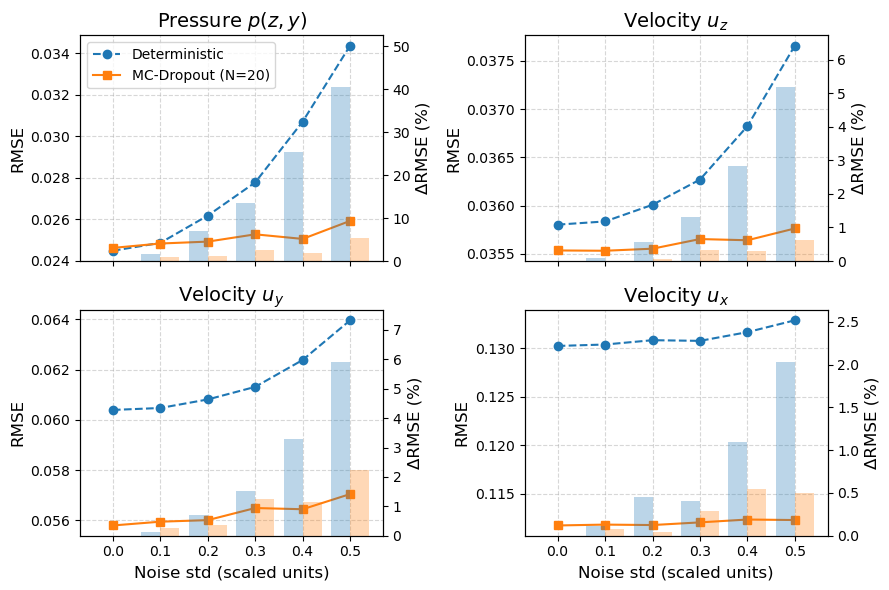

In [77]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharex=True)
axes = axes.ravel()

# Compute relative RMSE change (% increase from noise=0)
rel_det = (rmse_det / rmse_det[0] - 1.0) * 100
rel_mc  = (rmse_mc / rmse_mc[0] - 1.0) * 100

for i, ch in enumerate(channels):
    ax = axes[i]

    # --- Left y-axis: absolute RMSE ---
    ax.plot(noise_det, rmse_det[:, i], 'o--', label='Deterministic', color='tab:blue')
    ax.plot(noise_mc, rmse_mc[:, i], 's-', label='MC-Dropout (N=20)', color='tab:orange')
    ax.set_ylabel("RMSE", fontsize=12)
    ax.set_title(f"{ch}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- Right y-axis: relative change as bars ---
    ax2 = ax.twinx()
    width = (noise_det[1] - noise_det[0]) * 0.4  # bar width proportional to spacing
    ax2.bar(noise_det - width/2, rel_det[:, i], width=width, alpha=0.3, color='tab:blue')
    ax2.bar(noise_mc + width/2, rel_mc[:, i], width=width, alpha=0.3, color='tab:orange')
    ax2.set_ylabel("ΔRMSE (%)", fontsize=12)
    ax2.set_ylim(0, max(np.max(rel_det[:, i]), np.max(rel_mc[:, i])) * 1.3)

    # --- Shared labels and legends ---
    if i in [2, 3]:
        ax.set_xlabel("Noise std (scaled units)", fontsize=12)
    if i == 0:
        ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
#plt.savefig(working_dir + "/analysis/robustness_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


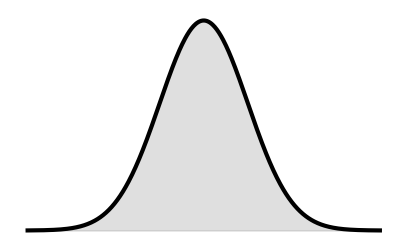

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Noise std
lam = 0.1
x = np.linspace(-0.4, 0.4, 500)
y = norm.pdf(x, loc=0, scale=lam)

# Create plot
plt.figure(figsize=(5, 3))
plt.plot(x, y, color="black", lw=3)
plt.fill_between(x, y, color="gray", alpha=0.25)

# Remove axes, ticks, and background
plt.axis("off")

# Save transparent image
plt.savefig("gaussian_noise_distribution.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()
